# HOWTO's and reusable python snippets

In [1]:
import numpy as np

from matplotlib import pyplot as plt
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

### Including images in markdown and specifing the size
<div>
<img src="TGMM_Blind_Elephant.png" width="200"/>
</div>

Or just quick inline

![Alt text](RISE_slideshow_icon.png)

Or side by side

<table>
<tr>
    <td> <img src="iconic_ENSO_elNino_lrg.jpg" alt="El Nino" style="width: 300px;"/> </td>
    <td> <img src="iconic_ENSO_laNina_lrg.jpg" alt="La Nina" style="width: 300px;"/> </td>
</tr>
</table>    

### Subplots with size and axis sharing

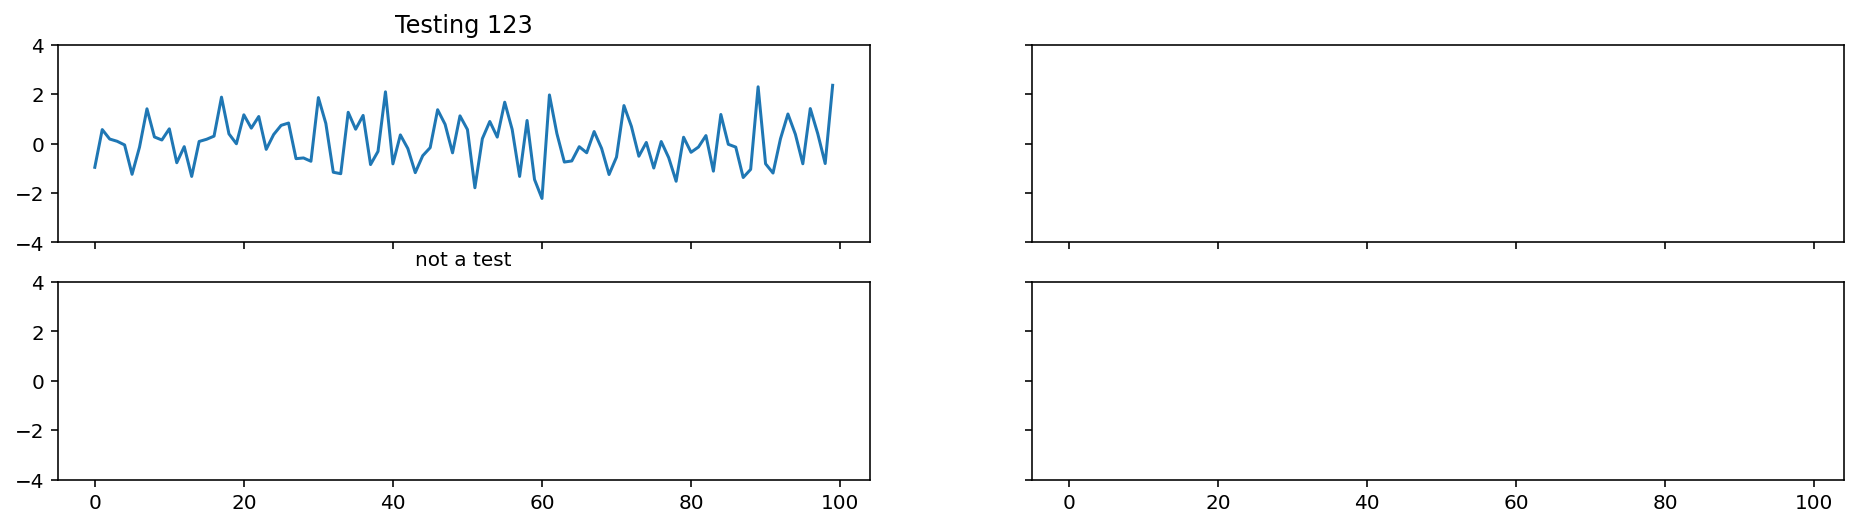

In [2]:
fig, axs = plt.subplots(2, 2, figsize=(16,4),sharey=True,sharex=True)
axs[0,0].plot(np.random.normal(size=100));
axs[0,0].set_title('Testing 123');
axs[0,0].set_ylim([-4,4]);
axs[0,0].set_xlabel('not a test');

### Functions

In [3]:
def cor(x,y):
    xa = x - np.nanmean(x)
    ya = y - np.nanmean(y)
    return np.nansum(xa*ya)/np.sqrt(np.nansum(xa**2)*np.nansum(ya**2))

### Read Nino 3.4 from the data library and compute anomaly wrt 1982-2010
Time may or may not work depending on your version of `netcdflib`

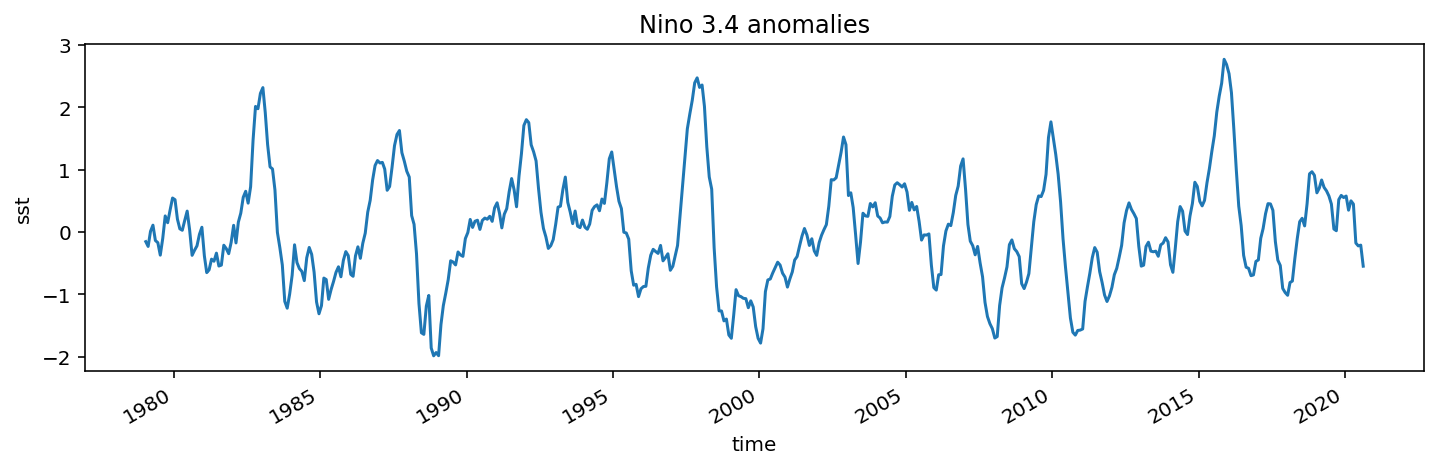

In [4]:
import xarray as xr

nino34_url="http://iridl.ldeo.columbia.edu/SOURCES/.NOAA/.NCDC/.ERSST/.version5/.sst/Y/-5/5/RANGEEDGES/X/190/240/RANGEEDGES/%5BX/Y%5Daverage/zlev/removeGRID/T/%28Jan%201979%29/last/RANGE/T/(days%20since%201960-01-01)streamgridunitconvert/dods"

n34_ds = xr.open_dataset(nino34_url)
n34c = n34_ds.sst.sel(T=slice('1982-01-01','2010-12-31')).groupby('T.month').mean('T')

n34a = n34_ds.sst.groupby('T.month') - n34c
fig, ax = plt.subplots(figsize=(12,3))
n34a.plot()
plt.title('Nino 3.4 anomalies');

### Read ONI from CPC

In [5]:
import pandas as pd

oni_url = "https://www.cpc.ncep.noaa.gov/data/indices/oni.ascii.txt"
oni_df = pd.read_fwf(oni_url)
oni_df.head()

,SEAS,YR,TOTAL,ANOM
0,DJF,1950,24.72,-1.53
1,JFM,1950,25.17,-1.34
2,FMA,1950,25.75,-1.16
3,MAM,1950,26.12,-1.18
4,AMJ,1950,26.32,-1.07


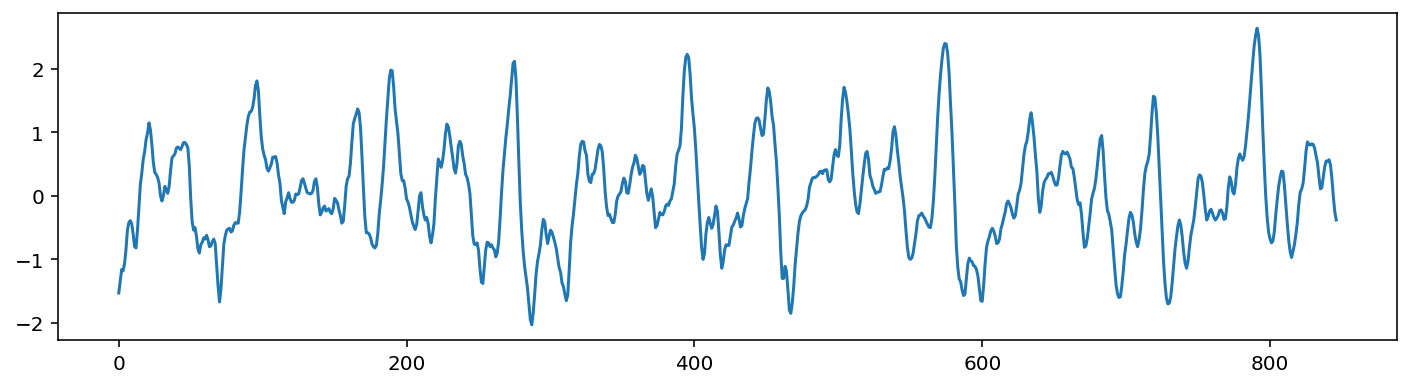

In [6]:
# no time coordinate
oni_df['ANOM'].plot(figsize=(12,3));

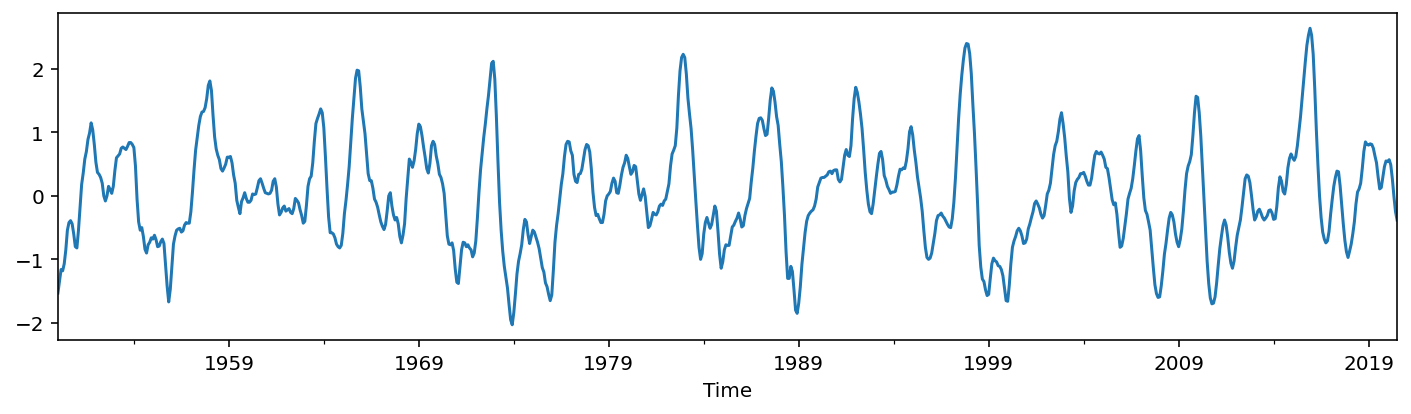

In [7]:
# sort of a time coordinate
n_months = len(oni_df) 
oni_df['Time'] = pd.to_datetime(pd.date_range('1950-01-01', periods=n_months, freq='M'))
oni_df.set_index('Time', inplace=True)
oni_df['ANOM'].plot(figsize=(12,3));

## `xarray` pcolor plots with coastlines centered on the Pacific

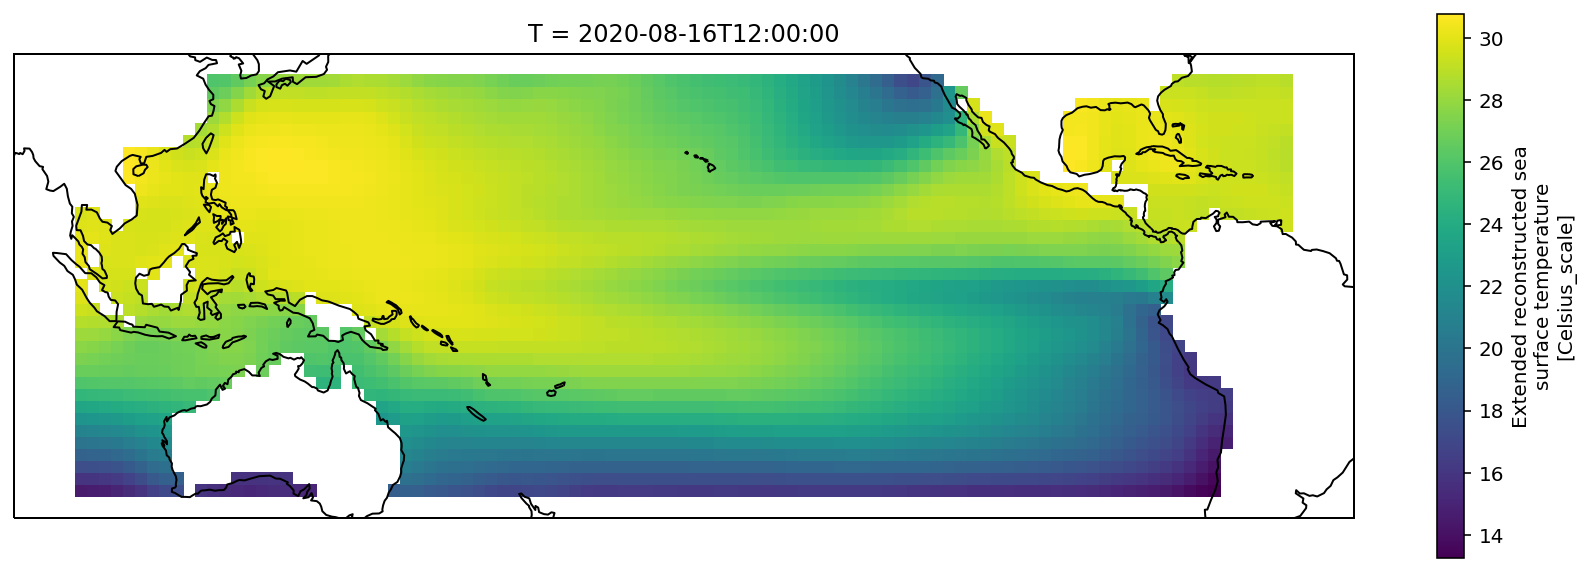

In [8]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature

ersst5_url="http://iridl.ldeo.columbia.edu/SOURCES/.NOAA/.NCDC/.ERSST/.version5/.sst/Y/-35/35/RANGEEDGES/X/100/300/RANGEEDGES/zlev/removeGRID/T/last/VALUE/T/(days%20since%201960-01-01)streamgridunitconvert/dods"
ersst5_ds = xr.open_dataset(ersst5_url)

proj_map = ccrs.PlateCarree(central_longitude=180)
proj_dta = ccrs.PlateCarree()

fig = plt.figure(figsize=(15,5))
ax = plt.subplot(projection=proj_map)

ersst5_ds.sst.plot(ax=ax, transform=proj_dta)
ax.coastlines();

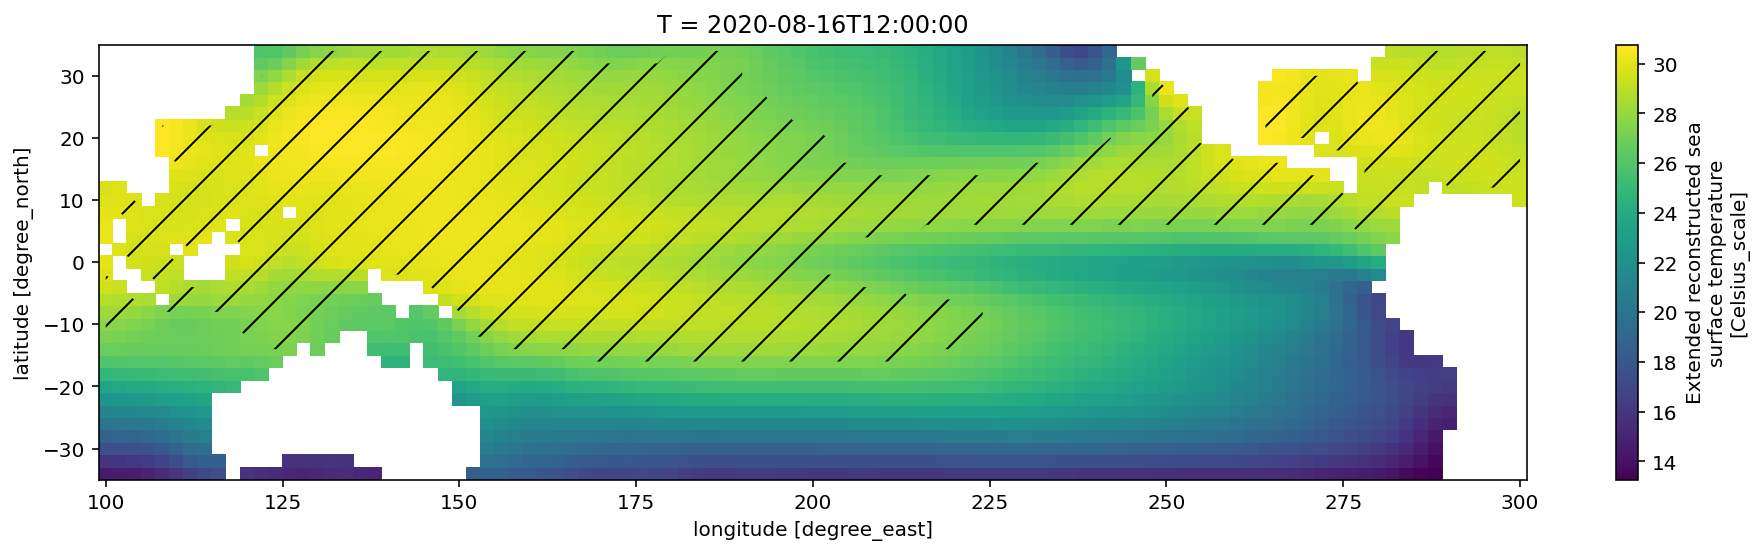

In [9]:
# bare bones with hatching
ersst5_ds.sst.plot(aspect=4,size=4);
lon = ersst5_ds.X
lat = ersst5_ds.Y

dta = ersst5_ds.sst.values.reshape(35, 101)
sig_value = 27
mask = np.zeros(dta.shape) ; mask[(np.abs(dta)<sig_value) | np.isnan(dta)] = np.nan
plt.contourf(lon, lat, mask,hatches=['/'],colors='none');

### Read something (elevation) from the data libaray and plot it on a map

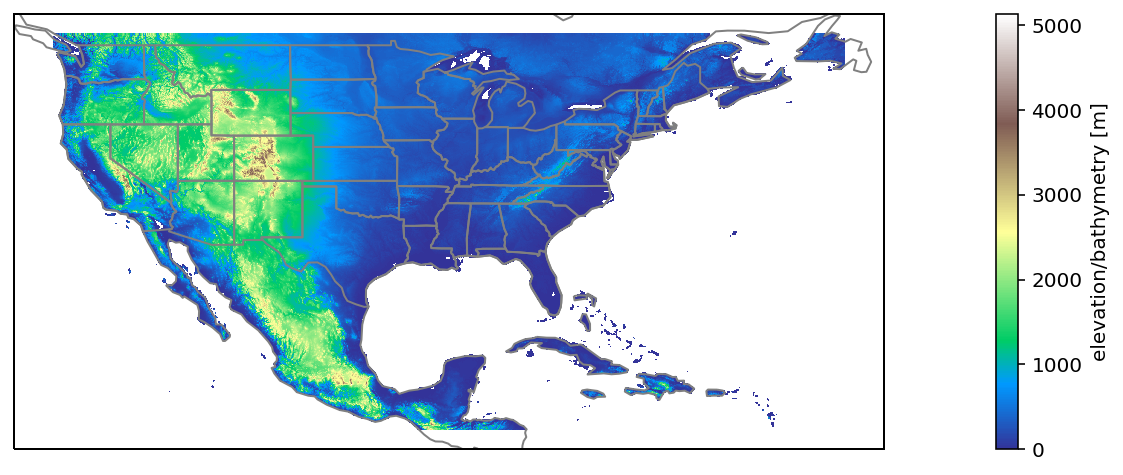

In [10]:
bath = xr.open_dataset('https://iridl.ldeo.columbia.edu/SOURCES/.NOAA/.NGDC/.ETOPO2v2/.z/X/-125./-55/RANGEEDGES/Y/15/50/RANGEEDGES/0/masklt/dods')

proj = ccrs.PlateCarree()
fig = plt.figure(figsize=(20,4))
ax = plt.subplot(projection=proj)

bath.z.plot(ax=ax, cmap='terrain', transform=proj)
ax.add_feature(cfeature.STATES, edgecolor='gray')
ax.coastlines(color='gray');

### Background NOT tranparent

`fig.set_facecolor("white")`

### xarray faceted plots

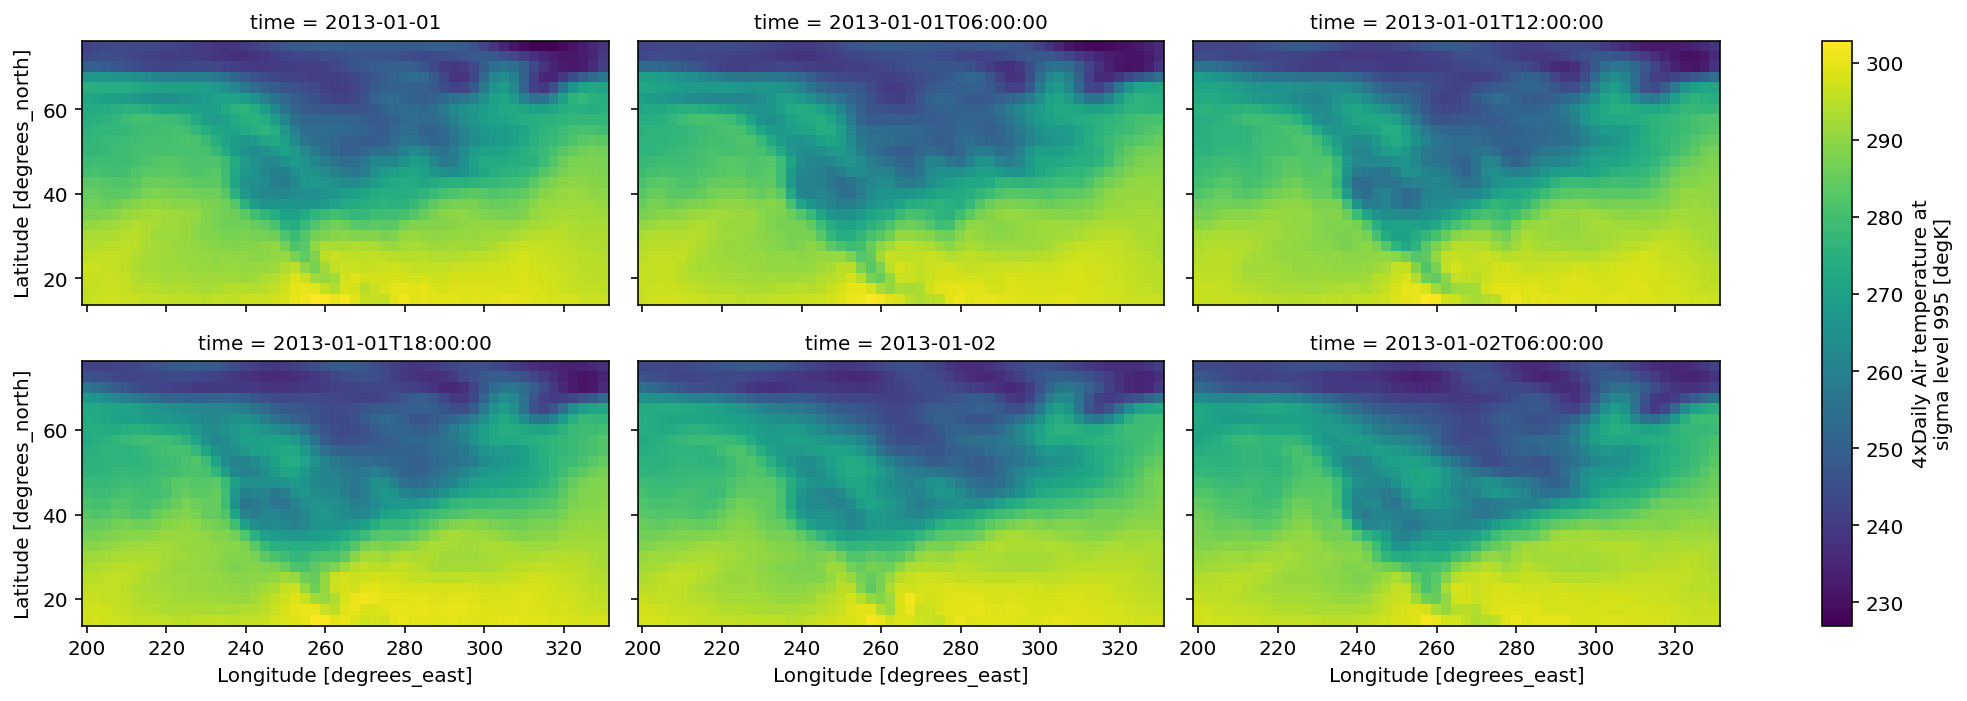

In [11]:
ds = xr.tutorial.open_dataset("air_temperature")
da = ds.air.isel(time=slice(None, 6))
# bare bones, no projection but ticks
da.plot(col='time', col_wrap=3, figsize=(15,5));

/Users/tippett/miniconda3/envs/pangeo/lib/python3.6/site-packages/xarray/plot/facetgrid.py:373: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  self.fig.tight_layout()


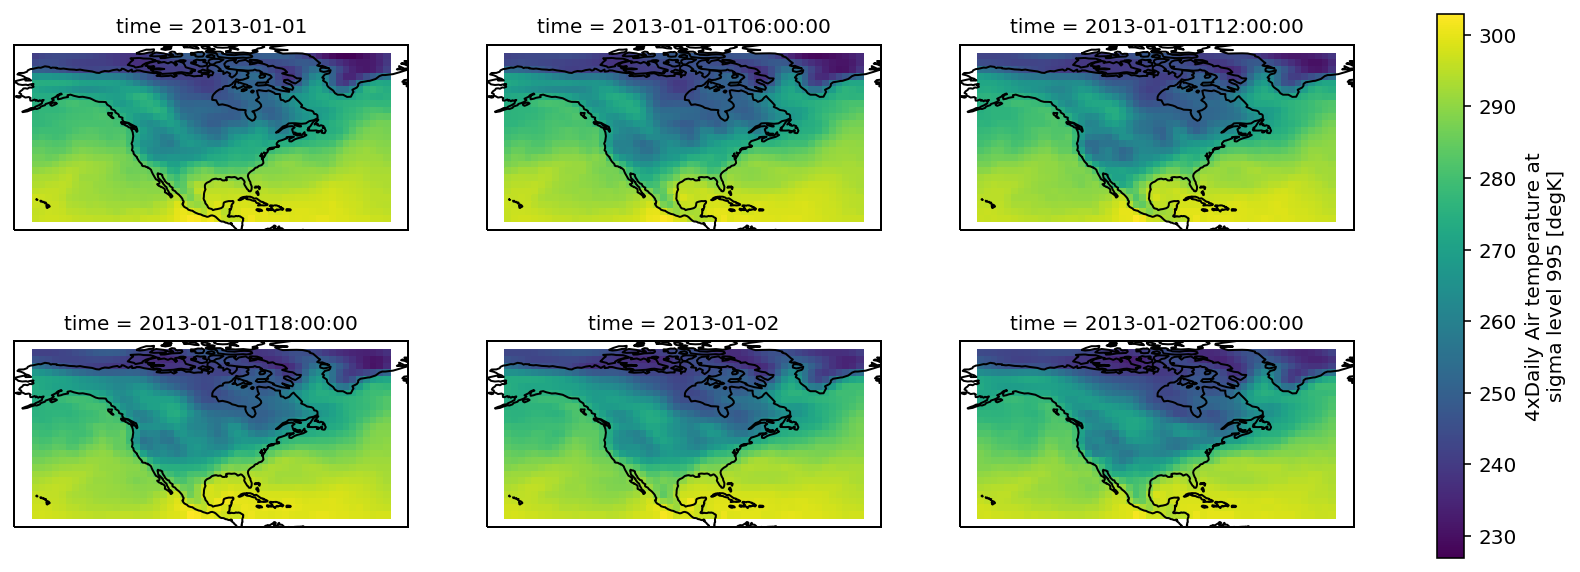

In [12]:
# bare bones with projection, coastlines, no ticks
proj = ccrs.PlateCarree()
g = da.plot(transform=proj, col='time', col_wrap=3, figsize=(15,5), subplot_kws={'projection':proj});
for ii, ax in enumerate(g.axes.flat):
    ax.coastlines()

/Users/tippett/miniconda3/envs/pangeo/lib/python3.6/site-packages/xarray/plot/facetgrid.py:373: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self.fig.tight_layout()


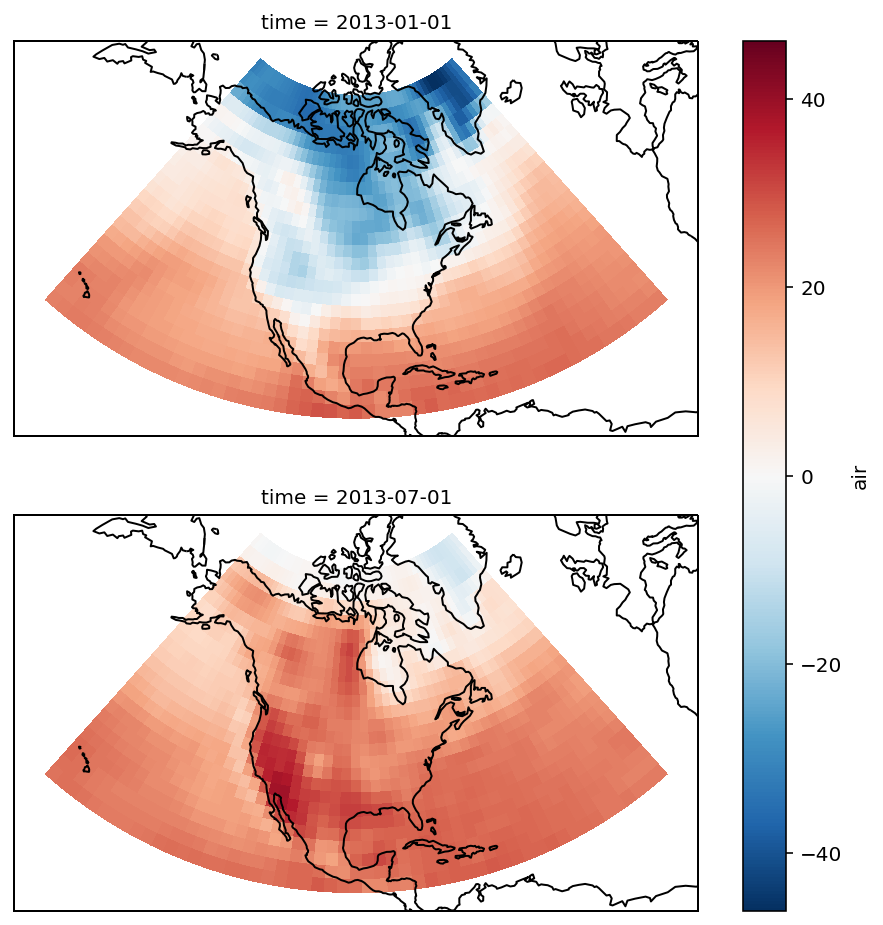

In [13]:
air = ds.air.isel(time=[0, 724]) - 273.15

# This is the map projection we want to plot *onto*
proj_map = ccrs.LambertConformal(central_longitude=-95, central_latitude=45)
proj_dta = ccrs.PlateCarree()  # the data's projection
p = air.plot(transform=proj_dta,  # the data's projection
             col='time', col_wrap=1,  # multiplot settings
             figsize=(8,8),
             #aspect=ds.dims['lon'] / ds.dims['lat'],  # for a sensible figsize
             subplot_kws={'projection': proj_map})  # the plot's projection
for ii, ax in enumerate(p.axes.flat):
    ax.coastlines()

In [14]:
XY_str = 'X/240/310/RANGE/Y/-30/30/RANGE/'
sst_climo_url = 'https://iridl.ldeo.columbia.edu/SOURCES/.NOAA/.NCDC/.ERSST/.version5/.sst/T/(Jan%201981)/(Dec%202010)/RANGE/yearly-climatology/' + XY_str + 'zlev/removeGRID/T/(days%20since%201960-01-01)streamgridunitconvert/dods'
sst_climo_ds = xr.open_dataset(sst_climo_url)

/Users/tippett/miniconda3/envs/pangeo/lib/python3.6/site-packages/xarray/plot/facetgrid.py:373: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  self.fig.tight_layout()


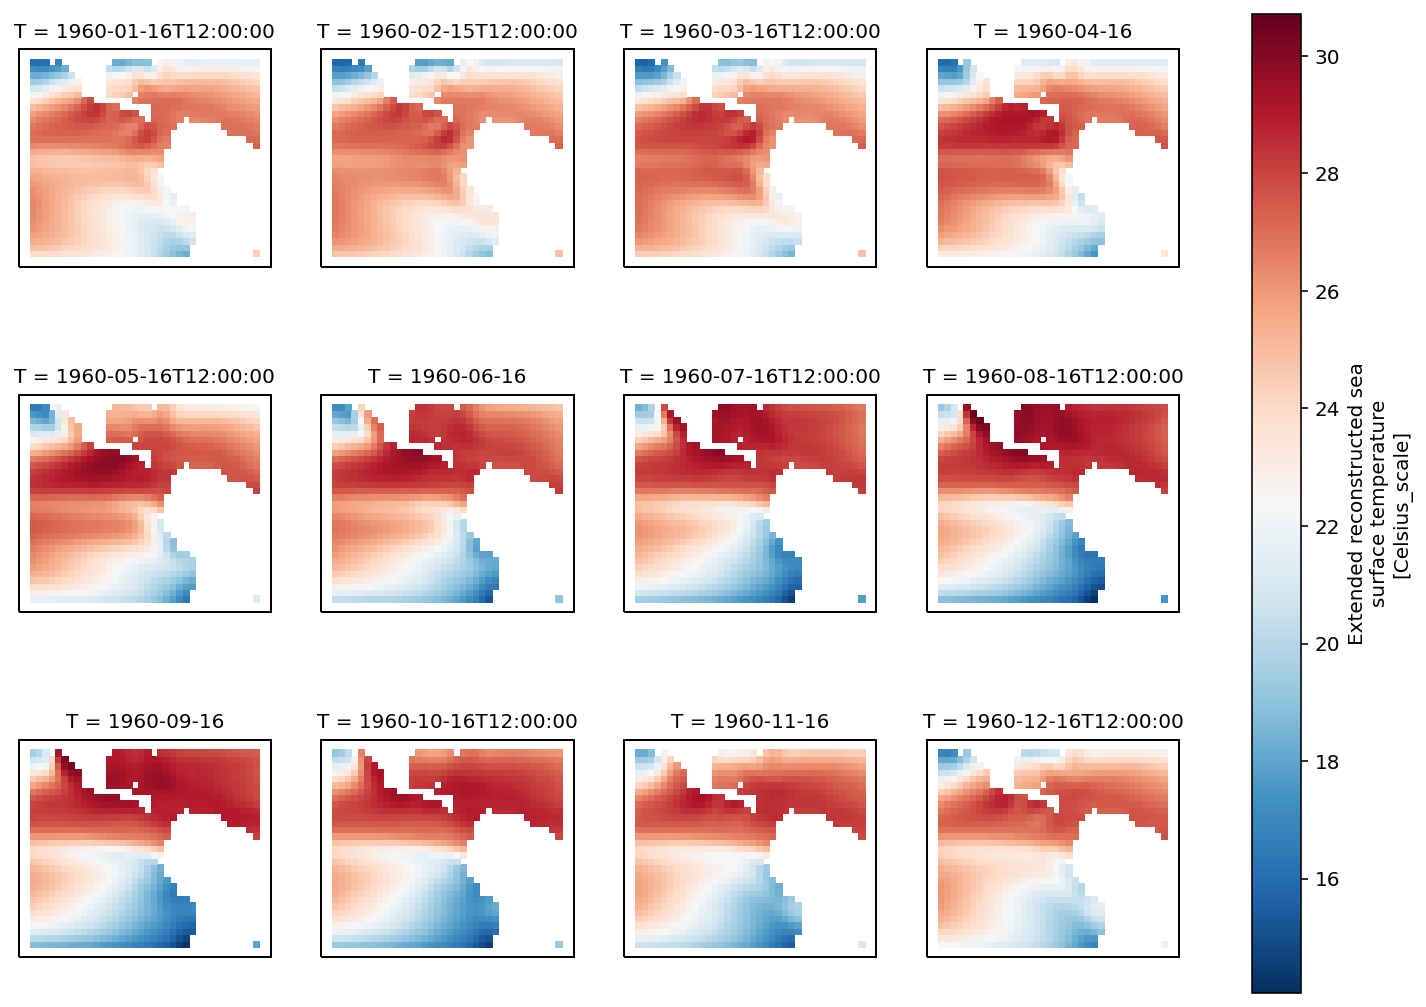

In [15]:
g = sst_climo_ds.sst.plot(x='X', y='Y', col='T', col_wrap=4, cmap='RdBu_r', subplot_kws={'projection': ccrs.PlateCarree()}, infer_intervals=True);

/Users/tippett/miniconda3/envs/pangeo/lib/python3.6/site-packages/xarray/plot/facetgrid.py:373: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  self.fig.tight_layout()
/Users/tippett/miniconda3/envs/pangeo/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:782: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  return super(GeoAxes, self).set_xticks(xticks, minor)
/Users/tippett/miniconda3/envs/pangeo/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:829: MatplotlibDeprecationWarning: Passing the minor parameter of set_yticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  return super(GeoAxes, self).set_yticks(yticks, minor)


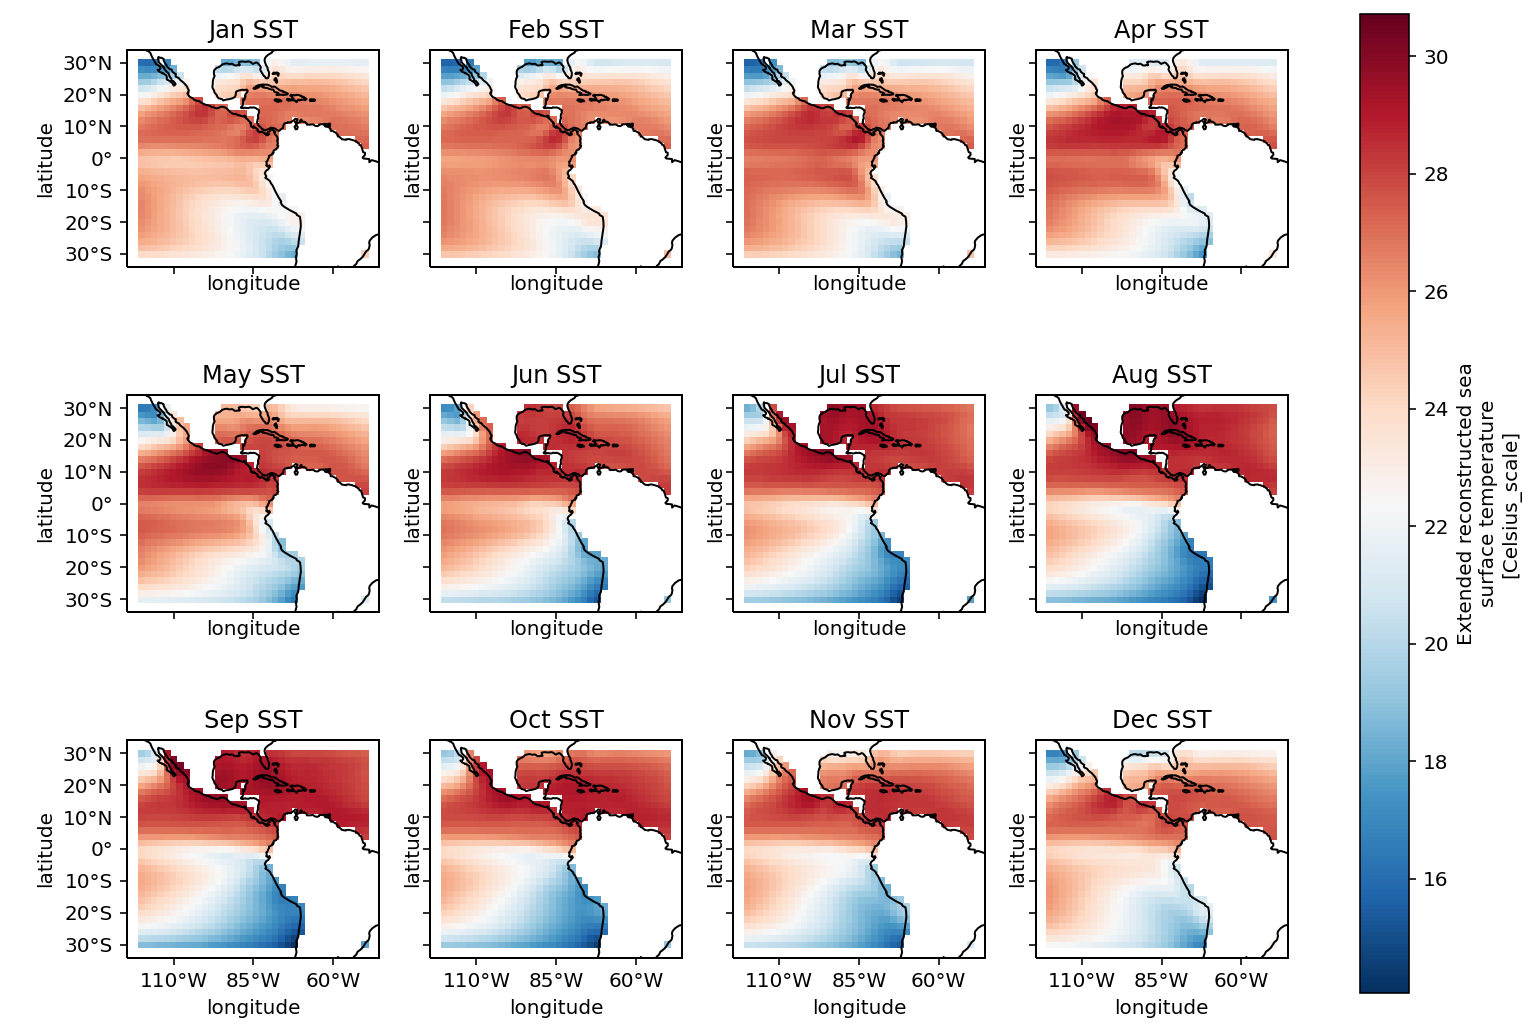

In [16]:
import xarray as xr
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

from matplotlib import pyplot as plt
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

from datetime import datetime
months =[datetime(2019, imon, 1) for imon in np.arange(1,12+1)]
month_str = [date_obj.strftime('%b') for date_obj in months]
m_str = [w[0] for w in month_str];

XY_str = 'X/240/310/RANGE/Y/-30/30/RANGE/'
sst_climo_url = 'https://iridl.ldeo.columbia.edu/SOURCES/.NOAA/.NCDC/.ERSST/.version5/.sst/T/(Jan%201981)/(Dec%202010)/RANGE/yearly-climatology/' + XY_str + 'zlev/removeGRID/T/(days%20since%201960-01-01)streamgridunitconvert/dods'
sst_climo_ds = xr.open_dataset(sst_climo_url)

g = sst_climo_ds.sst.plot.pcolormesh(x='X', y='Y', col='T', col_wrap=4, cmap='RdBu_r', subplot_kws={'projection': ccrs.PlateCarree()}, infer_intervals=True);
for ii, ax in enumerate(g.axes.flat):
    ax.set_title(month_str[ii] + ' SST')
    ax.coastlines()
    ax.set_xticks(np.arange(200,325,25)-360)
    ax.set_yticks(np.arange(-30,30+10,10))
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
    ax.set_xlabel('longitude')
    ax.set_ylabel('latitude')

### Bar plot with more than one bar

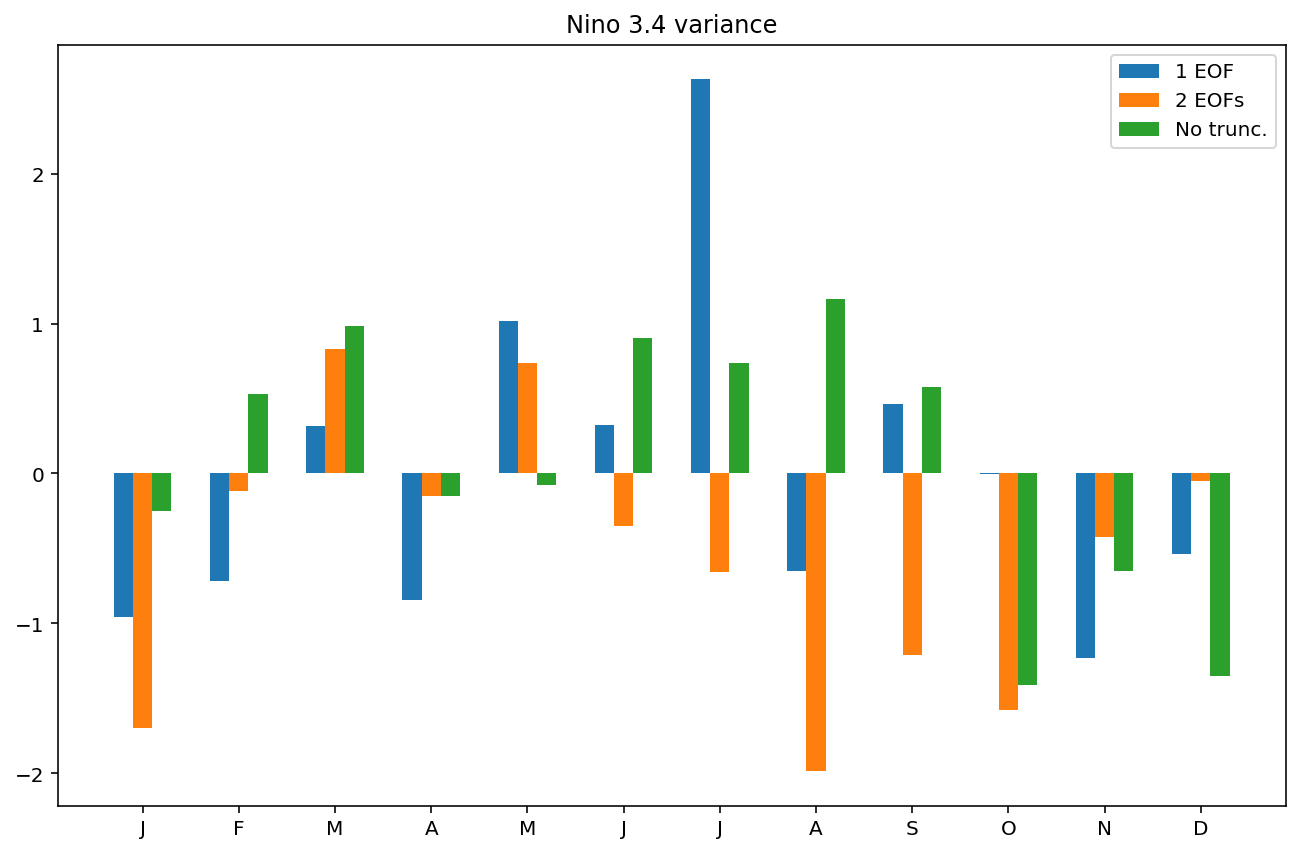

In [17]:
dta = np.random.normal(size=(3,12))
fig, ax = plt.subplots(figsize=(11, 7))
fig.set_facecolor("white")

width = 0.2
ax.bar(np.arange(1,12+1) - width,dta[0,:],width,label='1 EOF');
ax.bar(np.arange(1,12+1)        ,dta[1,:],width,label='2 EOFs');
ax.bar(np.arange(1,12+1) + width,dta[2,:],width,label='No trunc.');


ax.legend();
plt.xticks(np.arange(1,12+1),m_str);
plt.title('Nino 3.4 variance');

### Month strings

In [18]:
from datetime import datetime
months =[datetime(2019, imon, 1) for imon in np.arange(1,12+1)]
month_str = [date_obj.strftime('%b') for date_obj in months]
m_str = [w[0] for w in month_str]
print(month_str)
print(m_str)

['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
['J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D']


### Checker board plots

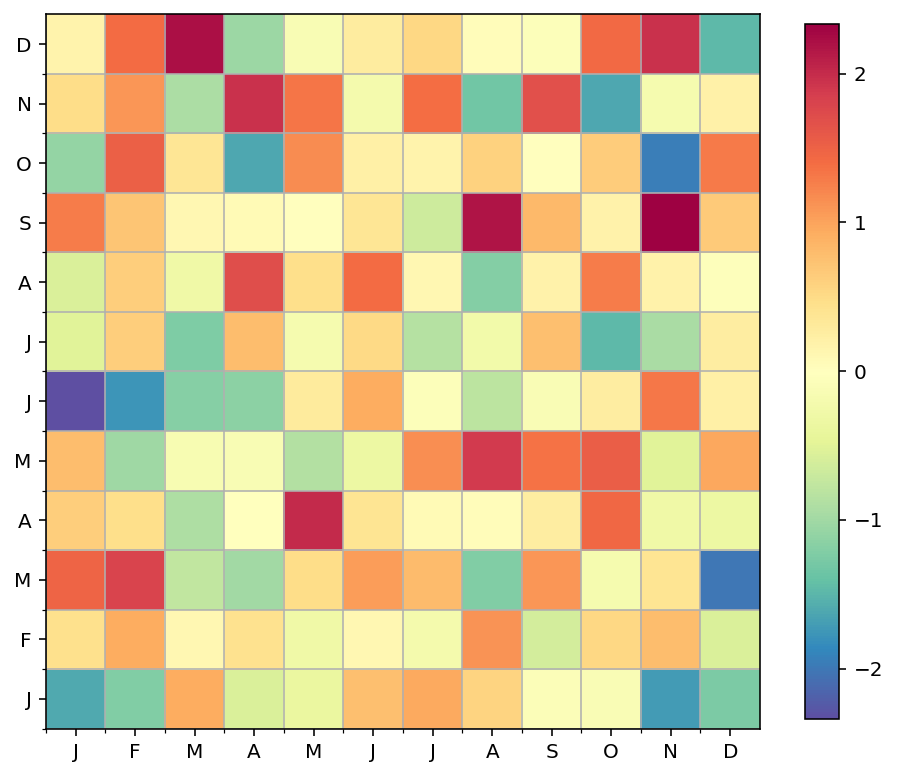

In [19]:
from matplotlib import cm

C = np.random.normal(size=(12,12))

fig, ax = plt.subplots(figsize=(8, 8))
fig.set_facecolor("white")

g = ax.pcolormesh(np.arange(0,12+1)+0.5, np.arange(0,12+1)+0.5, C, cmap=cm.Spectral_r);
ax.set_xticks(np.arange(0,12)+1);
ax.set_yticks(np.arange(0,12)+1);
ax.set_xticklabels(m_str)
ax.set_yticklabels(m_str)
ax.set_aspect(aspect=1)
plt.colorbar(g, ax=ax, shrink = 0.8);

ax.set_xticks(np.arange(0,12) + 0.5, minor=True);
ax.set_yticks(np.arange(0,12) + 0.5, minor=True);
plt.grid(which='minor')

In [20]:
C.shape

(12, 12)

### Shift an array (handy for converting from start-lead to target-lead)

In [21]:
a = np.arange(10)
print(a)
print(np.roll(a, 6))
print(np.roll(a, -6))

[0 1 2 3 4 5 6 7 8 9]
[4 5 6 7 8 9 0 1 2 3]
[6 7 8 9 0 1 2 3 4 5]


### Comprehension list

In [22]:
data = [ix + it + im for it in ('t1','t2','t3') for im in ('m1','m2','m3','m4') for ix in ('x1','x2')]
data

['x1t1m1',
 'x2t1m1',
 'x1t1m2',
 'x2t1m2',
 'x1t1m3',
 'x2t1m3',
 'x1t1m4',
 'x2t1m4',
 'x1t2m1',
 'x2t2m1',
 'x1t2m2',
 'x2t2m2',
 'x1t2m3',
 'x2t2m3',
 'x1t2m4',
 'x2t2m4',
 'x1t3m1',
 'x2t3m1',
 'x1t3m2',
 'x2t3m2',
 'x1t3m3',
 'x2t3m3',
 'x1t3m4',
 'x2t3m4']

In [23]:
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
colors

['#1f77b4',
 '#ff7f0e',
 '#2ca02c',
 '#d62728',
 '#9467bd',
 '#8c564b',
 '#e377c2',
 '#7f7f7f',
 '#bcbd22',
 '#17becf']

### Formatting strings
https://pyformat.info

In [24]:
'{} {}'.format('one', 'two')

'one two'

In [25]:
'{1} {0}'.format('one', 'two')

'two one'

In [26]:
'pi = {:4.2f}'.format(3.141592653589793)

'pi = 3.14'

In [27]:
'{:+d}'.format(42)

'+42'

In [ ]:
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib import pyplot as plt
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

stageiv_ds = xr.open_dataset('https://cida.usgs.gov/thredds/dodsC/stageiv_combined')
stageiv_ds.Total_precipitation_surface_1_Hour_Accumulation.isel(time=0).plot()

In [ ]:
import xarray as xr
from matplotlib import pyplot as plt
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

soi_url_does_NOT_work = 'http://iridl.ldeo.columbia.edu/SOURCES/.Indices/.soi/.c8110/.anomaly/T/%28Jan%201979%29/%28Dec%202019%29/RANGE/dods'
soi_url_does_work = 'http://iridl.ldeo.columbia.edu/SOURCES/.Indices/.soi/.c8110/.anomaly/dods'
soi_ds = xr.open_dataset(soi_url_does_NOT_work,decode_times=False)
fig, ax = plt.subplots(figsize=(20,5))
soi_ds.anomaly.plot();
plt.title('Southern Oscilation Index (1979-2019)');

In [ ]:
xr.__version__

In [ ]:
import netCDF4
netCDF4.Dataset(soi_url_does_NOT_work)

In [ ]:
netCDF4.__version__

In [ ]:
import netCDF4
soi_url_does_NOT_work = 'http://iridl.ldeo.columbia.edu/SOURCES/.Indices/.soi/.c8110/.anomaly/T/%28Jan%201979%29/VALUE/dods'
netCDF4.Dataset(soi_url_does_NOT_work)

### Read ingrid times

In [ ]:
import cftime
cftime.__version__

In [ ]:
import xarray as xr

url = 'http://iridl.ldeo.columbia.edu/SOURCES/.NOAA/.NCEP/.CPC/.CAMS_OPI/.v0208/.mean/.prcp/dods'
ds = xr.open_dataset(url,decode_times=False)

In [ ]:
def fix_calendar(ds, timevar='T'):
    if ds[timevar].attrs['calendar'] == '360':
        ds[timevar].attrs['calendar'] = '360_day'
    return ds

ds = fix_calendar(ds)
ds = xr.decode_cf(ds)
ds

In [ ]:
import xarray as xr
from matplotlib import pyplot as plt
import cftime

# function to help xarray understand months
def fix_calendar(ds, timevar='T'):
    if ds[timevar].attrs['calendar'] == '360':
        ds[timevar].attrs['calendar'] = '360_day'
    return ds

dl_url = 'http://iridl.ldeo.columbia.edu/'
ERSSTv5_url = 'SOURCES/.NOAA/.NCDC/.ERSST/.version5/.sst/'
n34box_url = 'Y/-5/5/RANGEEDGES/X/190/240/RANGEEDGES/[X/Y]average/'
n34_url = dl_url + ERSSTv5_url + n34box_url + "zlev/removeGRID/yearly-anomalies/dods"

n34_ds = xr.open_dataset(n34_url,decode_times=False)
n34_ds = fix_calendar(n34_ds)
n34_ds = xr.decode_cf(n34_ds)

fig, ax = plt.subplots(figsize=(20,5))
n34_ds.sst.plot();

In [ ]:
cftime.__version__

In [ ]:
xr.__version__

In [ ]:
import matplotlib
matplotlib.__version__

In [ ]:
import numpy as np
np.__version__

### Apply a function to an xarray dataset/dataarray

Apply KS test to all the grid points comparing to sets of time indices

In [ ]:
import xarray as xr
from scipy import stats

from matplotlib import pyplot as plt
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

def ks_test_map(x, t_ind1, t_ind2):
    ks_statistic,p_value = stats.ks_2samp(x.isel(T = t_ind1),x.isel(T = t_ind2))
    return xr.DataArray(p_value) 

global_prcp = 'http://iridl.ldeo.columbia.edu/SOURCES/.NOAA/.NCEP/.CPC/.Merged_Analysis/.monthly/.latest/.ver2/.prcp_est/'
t_range = 'T/%28Jan%201979%29/%28Aug%202020%29/RANGE/'
JJA = 'T/3/runningAverage/T/%28Jun-Aug%29VALUES/'
t_fix = 'T/(days%20since%201960-01-01)streamgridunitconvert/'
prcp_url = global_prcp + JJA + t_fix + 'dods'
prcp_ds = xr.open_dataset(prcp_url, decode_times=False)

nino34 ='http://iridl.ldeo.columbia.edu/SOURCES/.NOAA/.NCDC/.ERSST/.version5/.sst/Y/-5/5/RANGEEDGES/X/190/240/RANGEEDGES/%5BX/Y%5Daverage/zlev/removeGRID/'
nino34_url = nino34 + t_range + JJA + t_fix + 'dods'
n34_ds = xr.open_dataset(nino34_url, decode_times=False)

n34 = n34_ds.sst - n34_ds.sst.mean() 
t_nina = n34.values <= -0.4
t_nino = n34.values >= 0.33

da = prcp_ds.prcp_est
stacked = da.stack(allpoints=['X','Y'])  

p_map = stacked.groupby('allpoints').map(ks_test_map, args=(t_nina, t_nino))
p_map = p_map.unstack('allpoints')

In [ ]:
sig_map = p_map.values.copy()
sig_map[p_map < 0.05] = 1.
sig_map[p_map >= 0.05] = np.nan

proj_map = ccrs.PlateCarree(central_longitude=180)
proj_dta = ccrs.PlateCarree()

fig = plt.figure(figsize=(15,5))
ax = plt.subplot(projection=proj_map)

plt.pcolormesh(ds.X, ds.Y, sig_map.T, transform = proj_dta, vmax=1);
ax.coastlines();
plt.colorbar();

### Get color order

In [ ]:
# Get color order
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

In [ ]:
colors

In [ ]:
x = np.random.normal(size=32)
y = np.random.normal(size=32)
plt.plot(x)
plt.plot(y)
plt.plot(np.mean(x) + 0.0*x, color=colors[0])
plt.plot(np.mean(y) + 0.0*y, color=colors[1])